---
# Notebook para avaliar performance do modelo em produção

Neste notebook vamos explorar a parformance de captura de fraudes do modelo desenvolvido.

---

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import shap
import pickle
import json
import warnings
from scipy.stats import ks_2samp
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

# Configs Pandas
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 200

# Configs matplotlib
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 4)
plt.rcParams['axes.facecolor'] = '#f0f0f0'

main_colors = ["#fee605", "#454463"]

warnings.filterwarnings("ignore")

In [2]:
project_root = Path().resolve().parents[0]

In [3]:
df = pd.read_parquet(os.path.join(project_root, "data", "raw", "dados.parquet"))

df_train = pd.read_parquet(os.path.join(project_root, "data", "interim", "train.parquet"))
df_train = df_train.merge(df[["index", "score"]], on="index", how="inner")

df_test = pd.read_parquet(os.path.join(project_root, "data", "interim", "test.parquet"))
df_test = df_test.merge(df[["index", "score"]], on="index", how="inner")

# Load Model

In [4]:
model = pickle.load(open(os.path.join(project_root, "models", "wrapped", "model_pipeline_test.pkl"), "rb"))

In [5]:
model

Pipeline(steps=[('features_type',
                 FeaturesType(dtypes={'binary': ['n'], 'categorical': ['g', 'o', 'p'], 'datetime': ['fecha'], 'numerical': ['monto', 'a', 'b', 'c', 'd', 'e', 'f', 'h', 'k', 'l', 'm']})),
                ('build_features',
                 BuildFeatures(inference=True, ratio_features=['a', 'b', 'c', 'd', 'e', 'f', 'h', 'k', 'l', 'm', 'hour', 'weekday'])),
                ('fill_numeric',
                 NumericMissing(num_features=...
                 Selector(features=['monto', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'l', 'm', 'n', 'o', 'p', 'hour', 'dawn_operation', 'monto_div_a', 'monto_div_b', 'monto_div_c', 'monto_div_d', 'monto_div_e', 'monto_div_f', 'monto_div_h', 'monto_div_k', 'monto_div_l', 'monto_div_m', 'monto_div_hour', 'monto_div_weekday', 'f_lower', 'l_lower', 'm_lower', 'n_lower'])),
                ('model',
                 LGBMClassifier(class_weight='balanced',
                                early_stopping_rounds=10,
                                learning_rate=0.01070700999565044, max_depth=9,
                                min_child_samples=89, n_estimators=1000,
                                num_leaves=10, verbose=1))])

## Gerando scores

In [6]:
df_train['y_pred'] = model.predict(df_train)
df_train['new_score'] = (model.predict_proba(df_train)[:, 1] * 100).astype(int)

df_test['y_pred'] = model.predict(df_test)
df_test['new_score'] = (model.predict_proba(df_test)[:, 1] * 100).astype(int)

df = pd.concat([df_train, df_test])

# Avaliando modelo atual x novo modelo 

## Distribuição dos scores no periodo de teste 

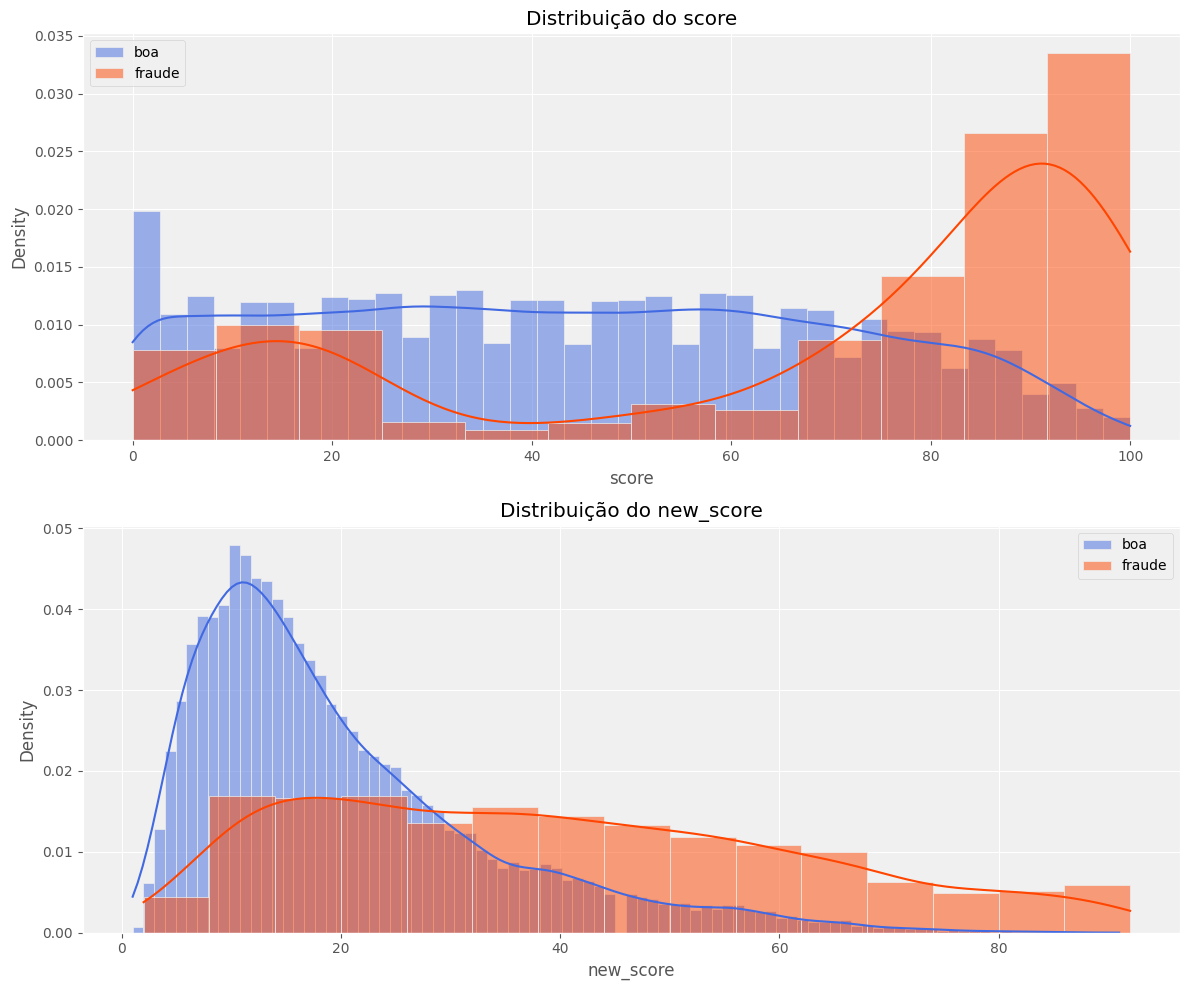

In [7]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.histplot(df_test[df_test['fraude'] == 0], x="score", kde=True, stat='density', label='boa', color="royalblue")
sns.histplot(df_test[df_test['fraude'] == 1], x="score", kde=True, stat='density', label='fraude', color="orangered")
plt.legend()
plt.title("Distribuição do score")

plt.subplot(2, 1, 2)
sns.histplot(df_test[df_test['fraude'] == 0], x="new_score", kde=True, stat='density', label='boa', color="royalblue")
sns.histplot(df_test[df_test['fraude'] == 1], x="new_score", kde=True, stat='density', label='fraude', color="orangered")
plt.legend()
plt.title("Distribuição do new_score")

plt.tight_layout()
plt.show()

## Ao longo do tempo

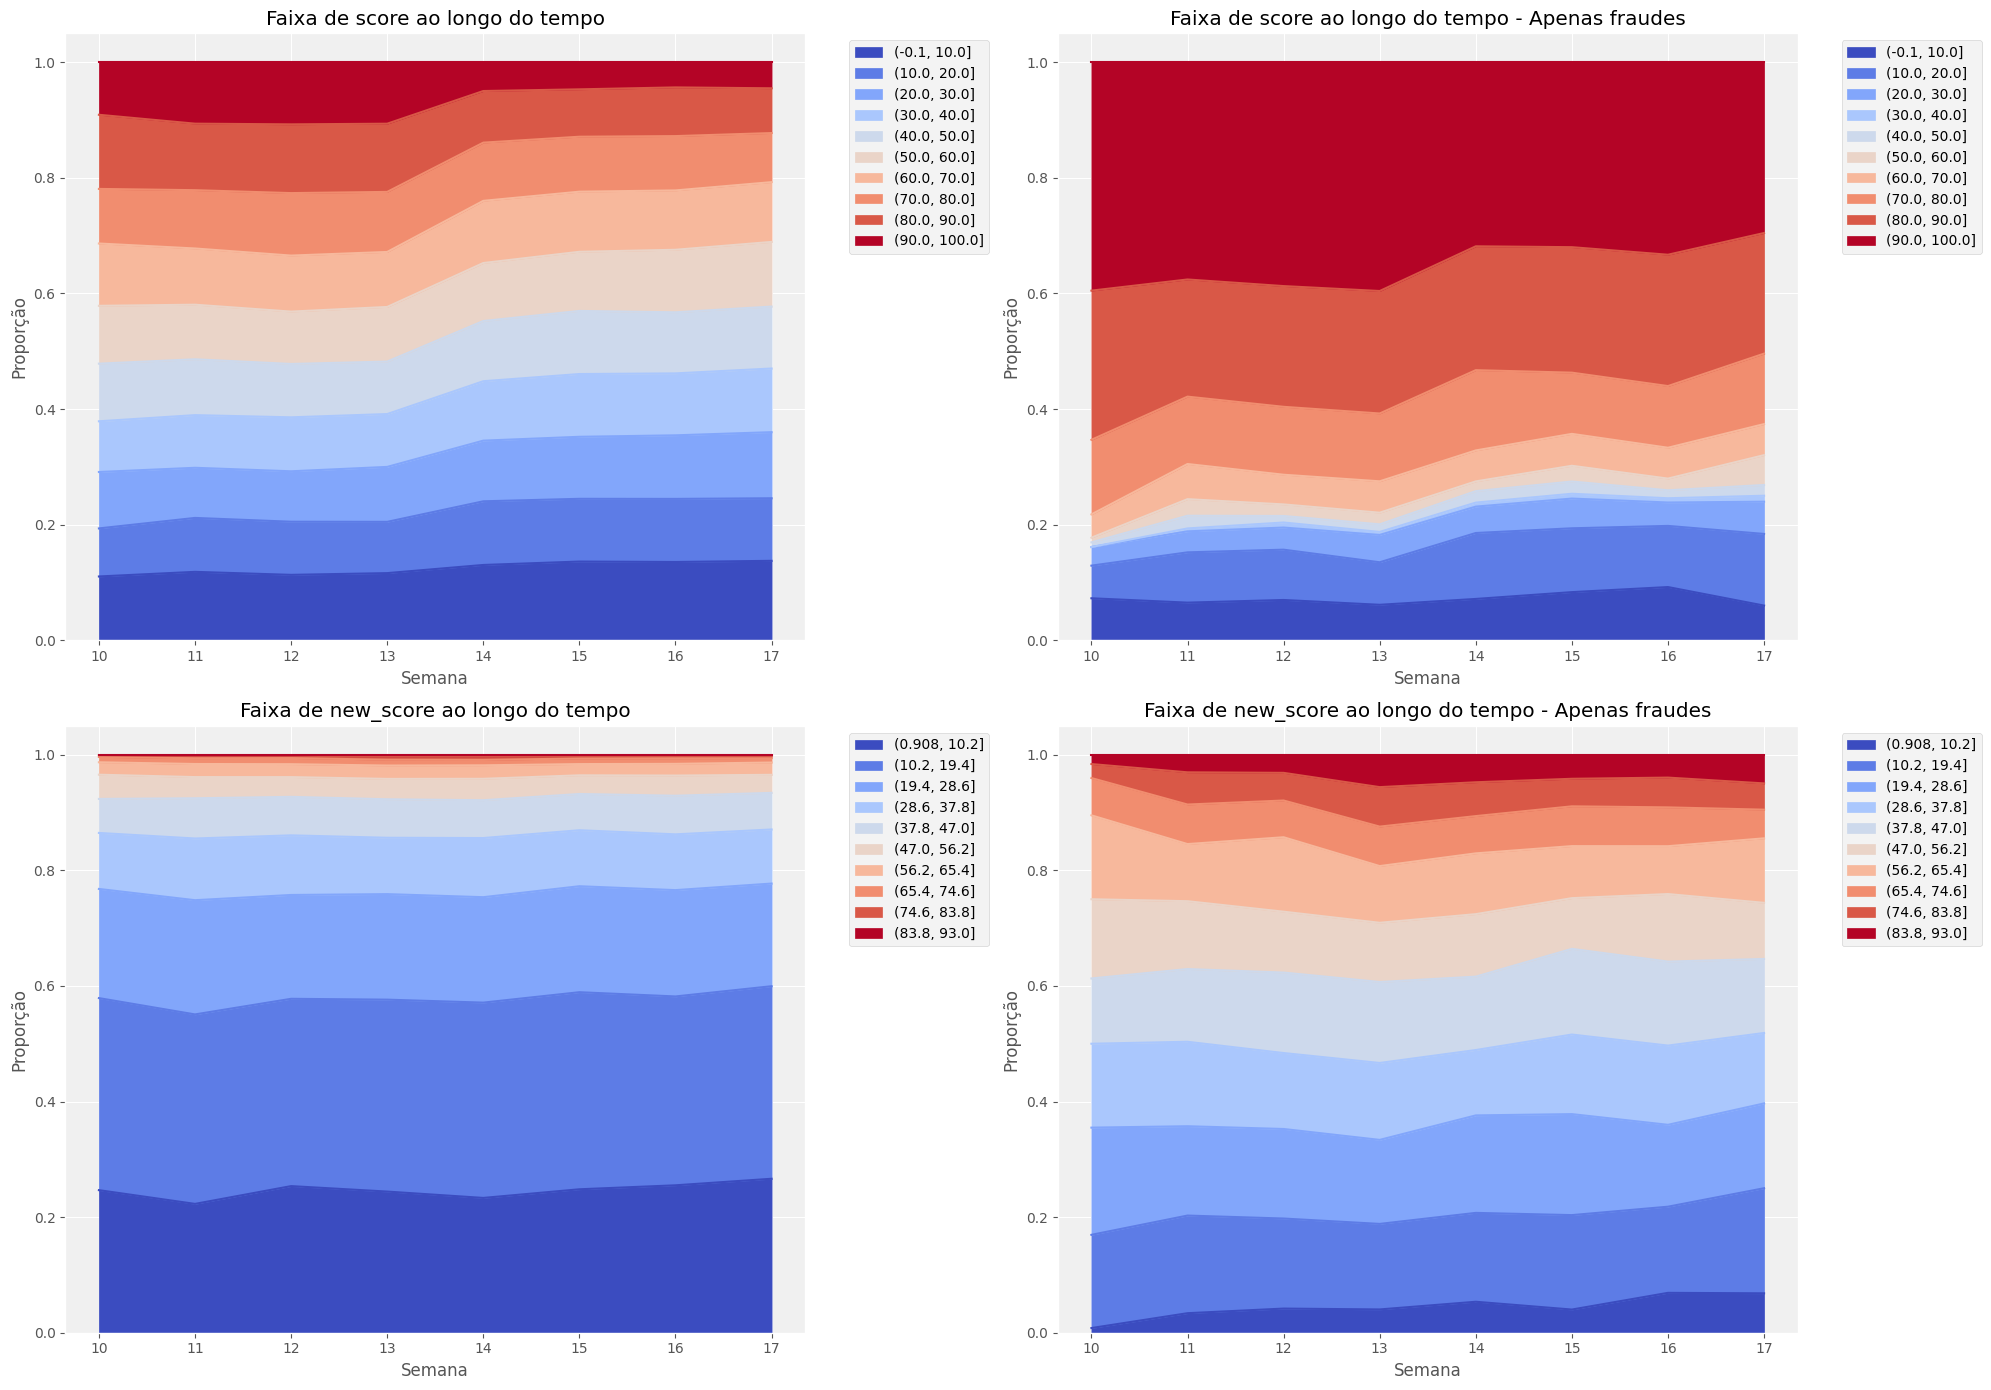

In [8]:
df['faixa_score'] = pd.cut(df['score'], bins=10)
df['faixa_new_score'] = pd.cut(df['new_score'], bins=10)

def plot_faixa_score(df, score_col, ax, title):
    pivot_table = df.groupby(["week_of_the_year", score_col]).size().unstack(fill_value=0)
    pivot_table_pct = pivot_table.div(pivot_table.sum(axis=1), axis=0)
    pivot_table_pct.plot(kind='area', stacked=True, cmap='coolwarm', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Semana")
    ax.set_ylabel("Proporção")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

f, ax = plt.subplots(2, 2, figsize=(20, 14))

# Plot para "score"
plot_faixa_score(df, "faixa_score", ax[0, 0], "Faixa de score ao longo do tempo")
plot_faixa_score(df[df['fraude'] == 1], "faixa_score", ax[0, 1], "Faixa de score ao longo do tempo - Apenas fraudes")

# Plot para "new_score"
plot_faixa_score(df, "faixa_new_score", ax[1, 0], "Faixa de new_score ao longo do tempo")
plot_faixa_score(df[df['fraude'] == 1], "faixa_new_score", ax[1, 1], "Faixa de new_score ao longo do tempo - Apenas fraudes")

plt.tight_layout()
plt.show()


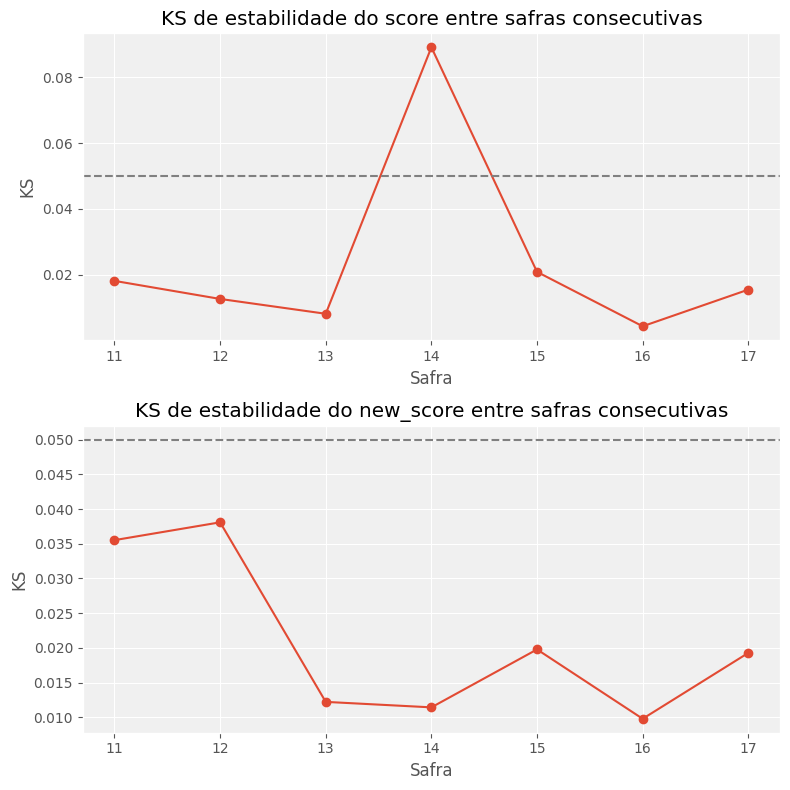

In [9]:
def plot_ks_stability_between_safras(df, score_cols, safra_col='safra'):
    safra_unicas = sorted(df[safra_col].unique())
    
    fig, axes = plt.subplots(len(score_cols), 1, figsize=(8, 4 * len(score_cols)))
    
    for idx, score_col in enumerate(score_cols):
        ks_results = []

        for i in range(len(safra_unicas) - 1):
            safra_atual = safra_unicas[i]
            safra_seguinte = safra_unicas[i + 1]

            scores_safra_atual = df[df[safra_col] == safra_atual][score_col]
            scores_safra_seguinte = df[df[safra_col] == safra_seguinte][score_col]

            ks_stat, _ = ks_2samp(scores_safra_atual, scores_safra_seguinte)

            ks_results.append({
                'safra_atual': safra_atual,
                'safra_seguinte': safra_seguinte,
                'KS': ks_stat
            })

        ks_df = pd.DataFrame(ks_results)

        ax = axes[idx] if len(score_cols) > 1 else axes
        ax.plot(ks_df['safra_seguinte'], ks_df['KS'], marker='o')
        ax.set_title(f'KS de estabilidade do {score_col} entre safras consecutivas')
        ax.set_xlabel('Safra')
        ax.set_ylabel('KS')
        ax.axhline(0.05, color='gray', linestyle='--')
    
    plt.tight_layout()
    plt.show()

plot_ks_stability_between_safras(df, score_cols=['score', 'new_score'], safra_col="week_of_the_year")


## Performance

### Confusion Matrix

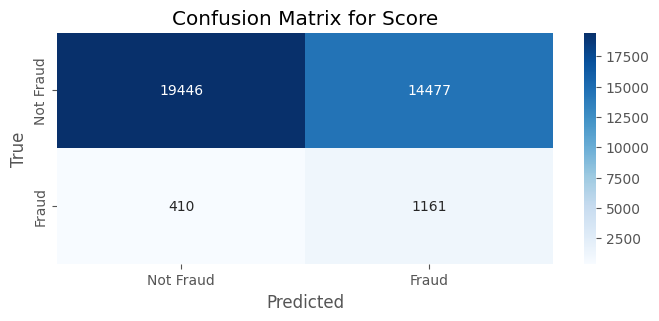

Classification Report for Score:

              precision    recall  f1-score   support

   Not Fraud       0.98      0.57      0.72     33923
       Fraud       0.07      0.74      0.13      1571

    accuracy                           0.58     35494
   macro avg       0.53      0.66      0.43     35494
weighted avg       0.94      0.58      0.70     35494



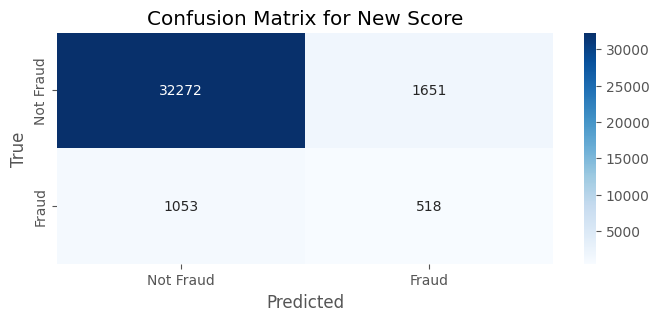

Classification Report for New Score:

              precision    recall  f1-score   support

   Not Fraud       0.97      0.95      0.96     33923
       Fraud       0.24      0.33      0.28      1571

    accuracy                           0.92     35494
   macro avg       0.60      0.64      0.62     35494
weighted avg       0.94      0.92      0.93     35494



In [10]:
def plot_confusion_matrix_and_classification_report(y_true, y_pred, labels=None, title_suffix=''):
    """Plota a matriz de confusão e o classification report.
    """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(8, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix {title_suffix}')
    plt.show()
    
    # Classification report
    report = classification_report(y_true, y_pred, target_names=labels)
    print(f"Classification Report {title_suffix}:\n")
    print(report)

y_true = df_test['fraude']

# For score
y_pred_score = (df_test['score'] >= 50).astype(int)
plot_confusion_matrix_and_classification_report(y_true, y_pred_score, labels=['Not Fraud', 'Fraud'], title_suffix='for Score')

# For new_score
y_pred_new_score = df_test['y_pred']
plot_confusion_matrix_and_classification_report(y_true, y_pred_new_score, labels=['Not Fraud', 'Fraud'], title_suffix='for New Score')

### Métricas Parciais

Em fraudes temos em geral dois principais KPIs: Recall e Impacto. O grande desafio desta área é aumentar o recall e reduzir o impacto, mas isso é difícil uma vez que são um trade-off. Então na maioria das vezes quando aumentamos o recall, também aumentamos o impacto e vice-versa.

Sabendo disso, devemos manter nosso impacto controlado, uma vez que em geral bloquamos transações e quando fazemos isso de forma errada, criamos um atrito com o cliente. Portanto para analisar de forma mais acertiva a performance de nossos modelo, avaliamos o recall para um determinado impacto definido, geralmente definido pela estratégia.

Exemplo:
- __ROC_AUC@0.05__: calculamos a área curva ROC, para um máx. FPR (impacto) de 5%.

In [26]:
def generate_model_metrics(y_test, y_pred_proba, max_fpr=0.05):
    """Model performance metrics"""
    
    # Calculate ROC AUC score with a partial area under the curve
    roc_auc = float(roc_auc_score(y_test, y_pred_proba))
    roc_auc_partial = float(roc_auc_score(y_test, y_pred_proba, max_fpr=max_fpr))
    
    # Calculate recall and precision with a threshold based on max_fpr
    threshold = np.percentile(y_pred_proba, 100 * (1 - max_fpr))
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    recall_partial = recall_score(y_test, y_pred)
    precision_partial = precision_score(y_test, y_pred)
    
    metrics = {
        f'ROC_AUC': roc_auc,
        f'ROC_AUC@{max_fpr}': roc_auc_partial,
        f'Recall@{max_fpr}': recall_partial,
        f'Precision@{max_fpr}': precision_partial
    }
    
    return metrics

#### Score

In [38]:
generate_model_metrics(df_test['fraude'], df_test['score'], max_fpr=0.01)

{'ROC_AUC': 0.7325855614185066,
 'ROC_AUC@0.01': 0.5431236767512629,
 'Recall@0.01': 0.12985359643539146,
 'Precision@0.01': 0.4668192219679634}

#### New Score

In [39]:
generate_model_metrics(df_test['fraude'], df_test['new_score'], max_fpr=0.01)

{'ROC_AUC': 0.7707232857247963,
 'ROC_AUC@0.01': 0.5558118257851147,
 'Recall@0.01': 0.1279439847231063,
 'Precision@0.01': 0.5193798449612403}

### Tabela de resultados

In [14]:
def gerar_metricas_por_score(df, 
                             score_col='score',
                             target_col='fraude',
                             valor_col='monto'):
    """
    Gera uma tabela de métricas por threshold de score.
    
    Args:
        df (pd.DataFrame): DataFrame contendo as colunas de score, fraude (0/1) e monto.
        score_col (str): Nome da coluna que contém o score.
        target_col (str): Nome da coluna que contém a variável fraude (0 ou 1).
        valor_col (str): Nome da coluna que contém o valor monetário (monto).

    Returns:
        pd.DataFrame: DataFrame com, para cada threshold, as métricas:
        [threshold, boas_#, fraudes_#, fraudes_$, recall, precision, recall_$, precision_$]
    """

    total_fraudes = df[target_col].sum()
    total_fraudes_valor = df.loc[df[target_col] == 1, valor_col].sum()

    thresholds = np.sort(df[score_col].unique())[::-1]

    resultados = []
    for thr in thresholds:
        df_acima_thr = df[df[score_col] >= thr]

        boas_num = df_acima_thr[df_acima_thr[target_col] == 0].shape[0]
        fraudes_num = df_acima_thr[df_acima_thr[target_col] == 1].shape[0]
        impacto = boas_num / df.shape[0]
        fraudes_val = df_acima_thr.loc[df_acima_thr[target_col] == 1, valor_col].sum()

        recall = fraudes_num / total_fraudes if total_fraudes > 0 else 0
        precision = fraudes_num / (fraudes_num + boas_num) if (fraudes_num + boas_num) > 0 else 0

        recall_val = fraudes_val / total_fraudes_valor if total_fraudes_valor > 0 else 0
        valor_acima_thr = df_acima_thr[valor_col].sum()
        precision_val = fraudes_val / valor_acima_thr if valor_acima_thr > 0 else 0

        resultados.append({
            'threshold': thr,
            'boas_#': boas_num,
            'fraudes_#': fraudes_num,
            'fraudes_$': fraudes_val,
            'impacto': impacto,
            'recall': recall,
            'precision': precision,
            'recall_$': recall_val,
            'precision_$': precision_val
        })

    df_resultados = pd.DataFrame(resultados)
    return df_resultados


In [15]:
df_test['faixa_score'] = pd.cut(df_test['score'], bins=10)
df_resultados_faixa_score = gerar_metricas_por_score(df_test, score_col='faixa_score')
df_resultados_faixa_score

,threshold,boas_#,fraudes_#,fraudes_$,impacto,recall,precision,recall_$,precision_$
0,"(90.0, 100.0]",1056,505,38350.14,0.029752,0.321451,0.323511,0.324654,0.387586
1,"(80.0, 90.0]",3629,853,69386.40,0.102243,0.542966,0.190317,0.587392,0.265103
2,"(70.0, 80.0]",6698,1028,81038.51,0.188708,0.654360,0.133057,0.686033,0.196371
3,"(60.0, 70.0]",10266,1112,88038.58,0.289232,0.707829,0.097732,0.745292,0.157475
4,"(50.0, 60.0]",14096,1159,89424.36,0.397138,0.737747,0.075975,0.757024,0.127433
5,"(40.0, 50.0]",17839,1183,91008.79,0.502592,0.753024,0.062191,0.770437,0.107135
6,"(30.0, 40.0]",21660,1196,91407.67,0.610244,0.761299,0.052328,0.773813,0.091651
7,"(20.0, 30.0]",25537,1267,99969.07,0.719474,0.806493,0.047269,0.846290,0.086647
8,"(10.0, 20.0]",29227,1442,110454.92,0.823435,0.917887,0.047018,0.935058,0.084399
9,"(-0.1, 10.0]",33923,1571,118126.25,0.955739,1.000000,0.044261,1.000000,0.078980


In [16]:
df_test['faixa_new_score'] = pd.cut(df_test['new_score'], bins=10)
df_resultados_faixa_new_score = gerar_metricas_por_score(df_test, score_col='faixa_new_score')
df_resultados_faixa_new_score

,threshold,boas_#,fraudes_#,fraudes_$,impacto,recall,precision,recall_$,precision_$
0,"(82.9, 92.0]",15,73,9257.85,0.000423,0.046467,0.829545,0.078373,0.731658
1,"(73.8, 82.9]",88,151,20387.58,0.002479,0.096117,0.631799,0.172591,0.558426
2,"(64.7, 73.8]",343,261,34997.50,0.009664,0.166136,0.432119,0.296272,0.429025
3,"(55.6, 64.7]",994,406,47292.92,0.028005,0.258434,0.290000,0.400359,0.322602
4,"(46.5, 55.6]",2053,580,60873.08,0.057841,0.369192,0.220281,0.515322,0.242086
5,"(37.4, 46.5]",4023,780,80020.70,0.113343,0.496499,0.162399,0.677417,0.201135
6,"(28.3, 37.4]",7211,988,97894.13,0.203161,0.628899,0.120503,0.828725,0.162212
7,"(19.2, 28.3]",13451,1213,104741.59,0.378965,0.772120,0.082720,0.886692,0.119583
8,"(10.1, 19.2]",24863,1463,114904.98,0.700485,0.931254,0.055572,0.972730,0.092426
9,"(0.909, 10.1]",33923,1571,118126.25,0.955739,1.000000,0.044261,1.000000,0.078980


### Curva ROC & Precison-Recall

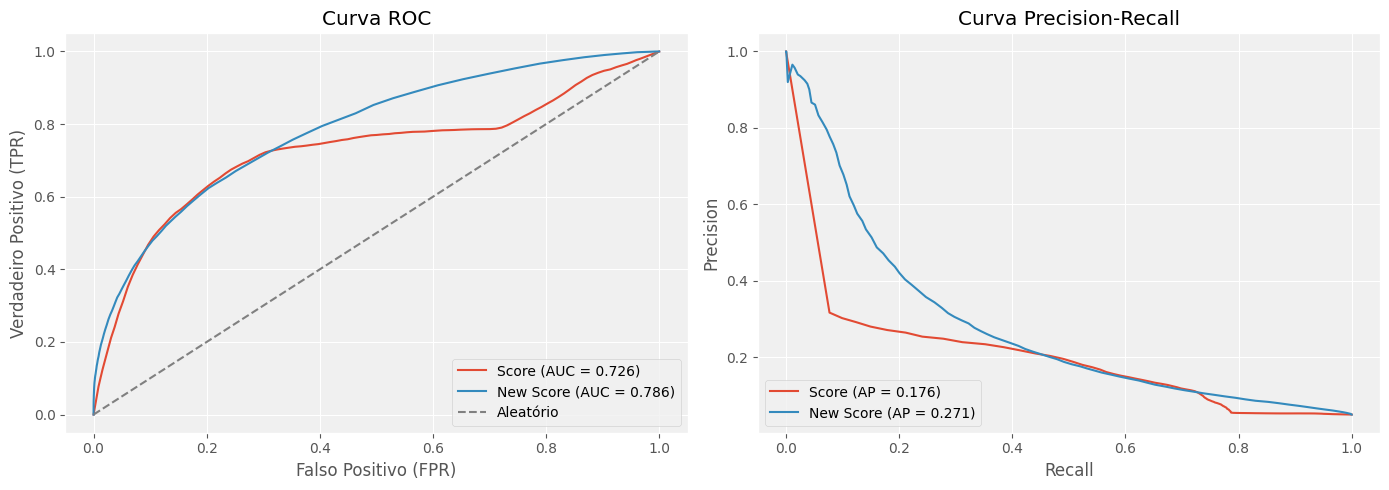

In [17]:
def plotar_roc_e_precision_recall(y_true, y_scores, labels_modelos):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for y_score, label_modelo in zip(y_scores, labels_modelos):
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_value = roc_auc_score(y_true, y_score)
        
        # Curva Precision-Recall
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        avg_precision = average_precision_score(y_true, y_score)
        
        # Gráfico da curva ROC
        axes[0].plot(fpr, tpr, label=f"{label_modelo} (AUC = {auc_value:.3f})")
        
        # Gráfico da curva Precision-Recall
        axes[1].plot(recall, precision, label=f"{label_modelo} (AP = {avg_precision:.3f})")
    
    # Configurações do gráfico ROC
    axes[0].plot([0, 1], [0, 1], linestyle='--', label="Aleatório", color='gray')
    axes[0].set_xlabel("Falso Positivo (FPR)")
    axes[0].set_ylabel("Verdadeiro Positivo (TPR)")
    axes[0].set_title("Curva ROC")
    axes[0].legend(loc="lower right")
    
    # Configurações do gráfico Precision-Recall
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Curva Precision-Recall")
    axes[1].legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()

# Chamando a função para plotar as curvas para score e new_score
plotar_roc_e_precision_recall(df["fraude"], [df["score"], df["new_score"]], ["Score", "New Score"])

### Avaliando ao longo do tempo

In [18]:
def metrics_time_series(df):
    # Inicializa as listas para armazenar as métricas por semana
    semanas = sorted(df['week_of_the_year'].unique())
    metrics = {
        'score': {'roc_auc': [], 'ks': [], 'roc_auc_005': []},
        'new_score': {'roc_auc': [], 'ks': [], 'roc_auc_005': []}
    }
    
    for semana in semanas:
        df_semana = df[df['week_of_the_year'] == semana]
        
        for score_type in ['score', 'new_score']:
            # Cálculo do ROC AUC
            roc_auc = roc_auc_score(df_semana["fraude"], df_semana[score_type])
            metrics[score_type]['roc_auc'].append(roc_auc)
            
            # Cálculo do ROC AUC com FPR máximo de 0.05
            roc_auc_005 = roc_auc_score(df_semana["fraude"], df_semana[score_type], max_fpr=0.05)
            metrics[score_type]['roc_auc_005'].append(roc_auc_005)
            
            # Cálculo do KS usando roc_curve
            fpr, tpr, _ = roc_curve(df_semana["fraude"], df_semana[score_type])
            ks = np.max(np.abs(tpr - fpr))
            metrics[score_type]['ks'].append(ks)
            
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    # Gráfico 1: ROC AUC por semana
    axes[0].plot(semanas, metrics['score']['roc_auc'], marker='o', label='Score')
    axes[0].plot(semanas, metrics['new_score']['roc_auc'], marker='o', label='New Score')
    axes[0].set_title('ROC AUC por Semana')
    axes[0].set_xlabel('Semana')
    axes[0].set_ylabel('ROC AUC')
    axes[0].set_ylim(0.5, 1)
    axes[0].legend()
    
    # Gráfico KS por semana
    axes[1].plot(semanas, metrics['score']['ks'], marker='o', label='Score')
    axes[1].plot(semanas, metrics['new_score']['ks'], marker='o', label='New Score')
    axes[1].set_title('KS por Semana')
    axes[1].set_xlabel('Semana')
    axes[1].set_ylabel('KS')
    axes[1].legend()
    
    # Gráfico 3: ROC_AUC@0.05 por semana
    axes[2].plot(semanas, metrics['score']['roc_auc_005'], marker='o', label='Score')
    axes[2].plot(semanas, metrics['new_score']['roc_auc_005'], marker='o', label='New Score')
    axes[2].set_title('ROC AUC @ 0.05 por Semana')
    axes[2].set_xlabel('Semana')
    axes[2].set_ylabel('ROC AUC @ 0.05')
    axes[2].set_ylim(0.5, 1)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

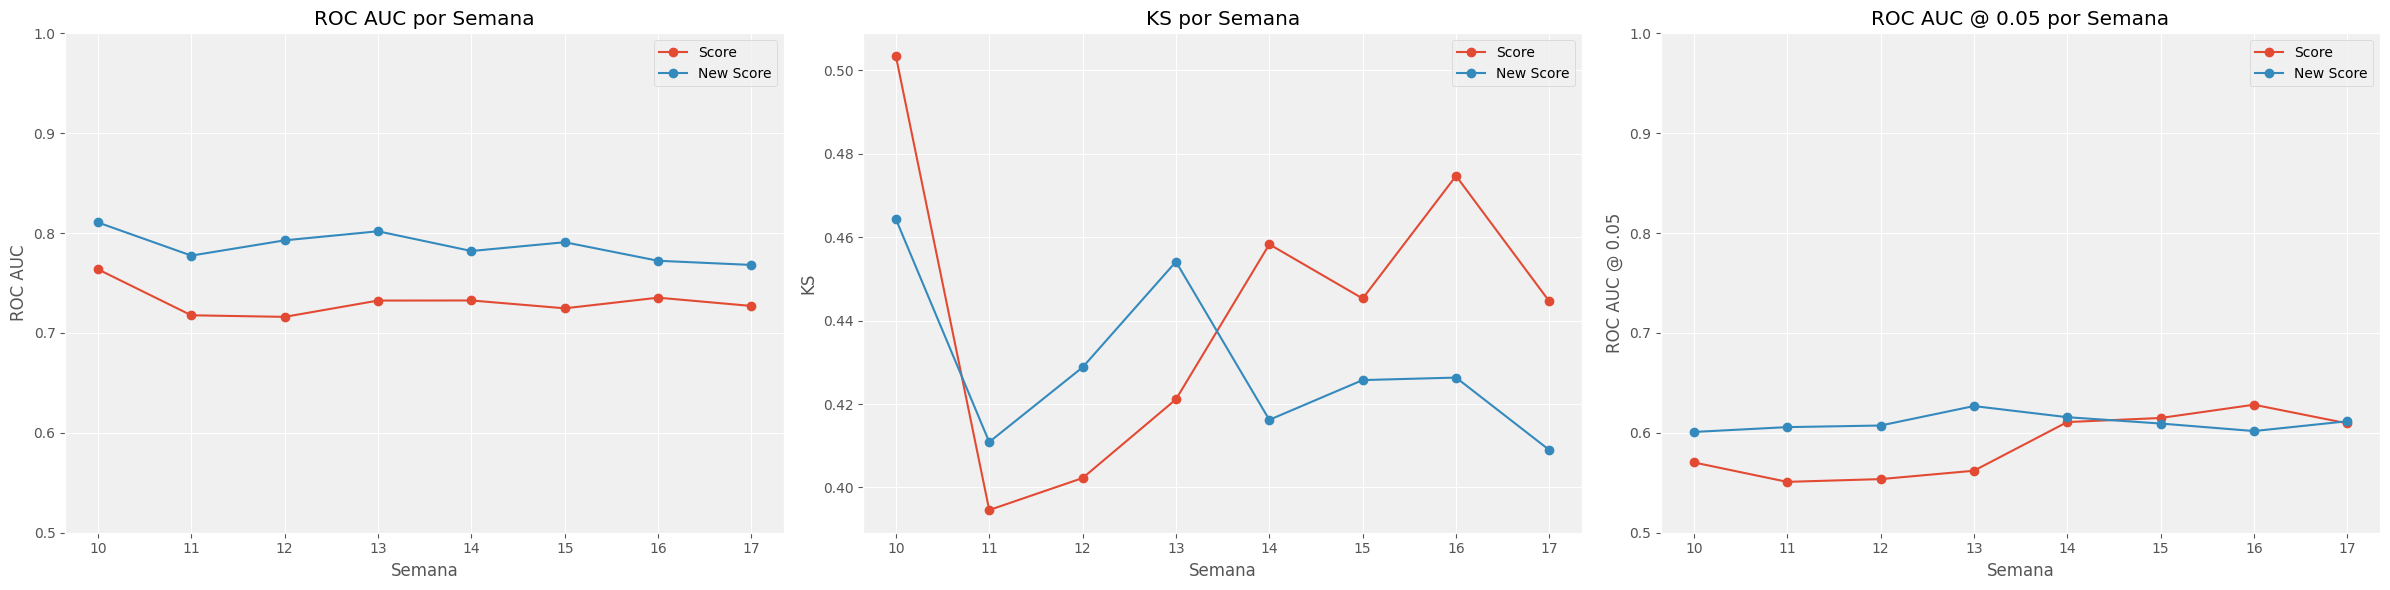

In [19]:
metrics_time_series(df)

# Explicabilidade do Modelo

In [20]:
predictor = pickle.load(open(os.path.join(project_root, "models", "predictors", "model.pkl"), 'rb'))

## Feature Importance

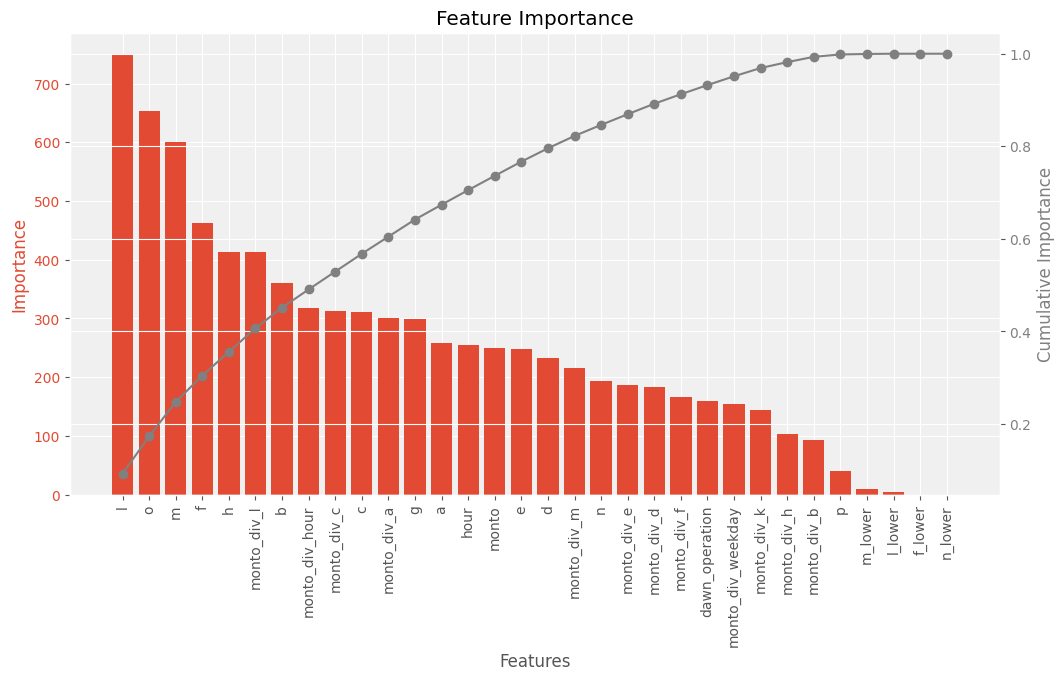

In [21]:
# Criar o DataFrame de importância das variáveis
df_importance = pd.DataFrame({'feature': predictor.feature_names_in_, 'importance': predictor.feature_importances_}).sort_values(by='importance', ascending=False).reset_index(drop=True)
df_importance['importance_cumsum'] = df_importance['importance'].cumsum()
df_importance['importance_perc'] = df_importance['importance_cumsum'] / df_importance['importance_cumsum'].max()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(df_importance['feature'], df_importance['importance'])
ax1.set_xlabel('Features')
ax1.set_ylabel('Importance', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_xticklabels(df_importance['feature'], rotation=90)

ax2 = ax1.twinx()
ax2.plot(df_importance['feature'], df_importance['importance_perc'], color='gray', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Importance', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()


## SHAP

In [22]:
df_test_transformed = model[:-1].transform(df_test)

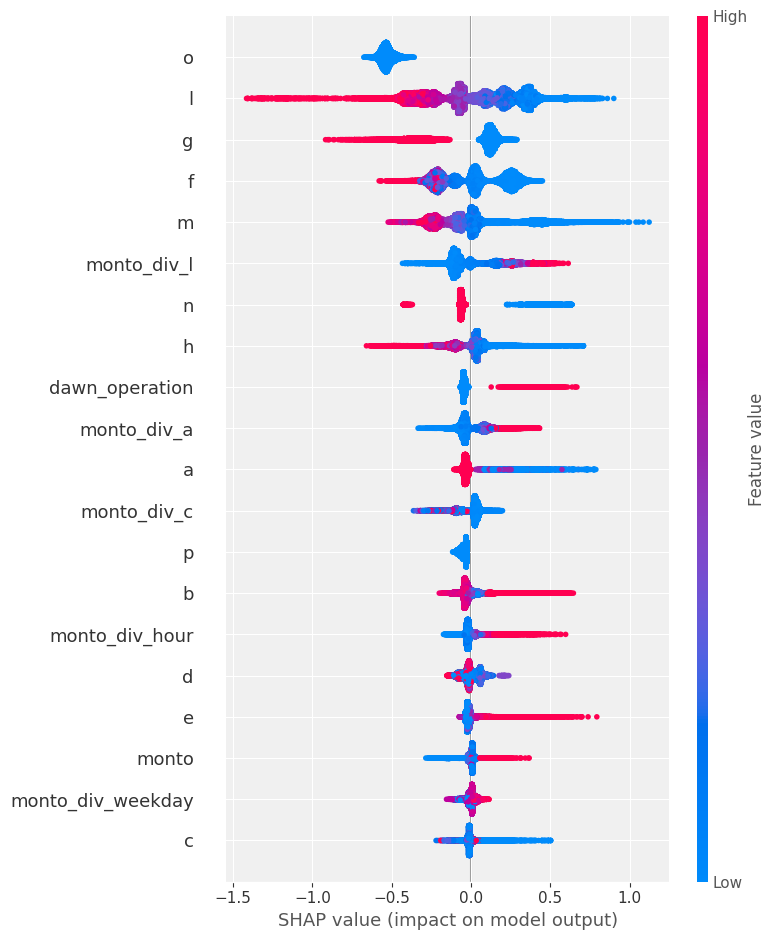

In [23]:
explainer = shap.TreeExplainer(predictor)
shap_values = explainer(df_test_transformed[predictor.feature_names_in_])
shap.summary_plot(shap_values, df_test_transformed[predictor.feature_names_in_])

---
# Resumo

- O modelo desenvolvido em geral, superou a performance do modelo em produção, principalmente em regiões de baixíssimo impacto.
- Além de que também se mostrou mais estável ao longo do tempo.